<a href="https://colab.research.google.com/github/pkirti33/video_classification_pytorch/blob/main/video_classification_minir3d18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -e .

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
# device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Working with Data

## Upload Data from Kaggle

In [ ]:
import ipdb
import av
from torch import nn
import os
import shutil
import random
import zipfile

In [ ]:
# PREP KAGGLE API AND DOWNLOAD DATA

# upload kaggle.json here
from google.colab import files
files.upload()

# make kaggle directory and upload .json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# download kaggle data from https://www.kaggle.com/datasets/khanhvudo72/ucf11updated
! kaggle datasets download -d khanhvudo72/ucf11updated

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/khanhvudo72/ucf11updated
License(s): unknown
100% 0.98G/0.98G [01:02<00:00, 21.4MB/s]
100% 0.98G/0.98G [01:02<00:00, 17.0MB/s]


In [ ]:
# ORGANIZE DATA INTO FOLDERS AND UNZIP

# create new folder "data" at base level of the Google Colab directory
data_folder = '/content/data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# extract the contents of the zip file into the "data" folder
zip_file_path = '/content/ucf11updated.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_folder)

print("Extraction complete.")

Extraction complete.


In [ ]:
# REMOVE UNECESSARY FOLDERS

data_folder = '/content/data/UCF11_updated_mpg'

# iterate through all subdirectories within the data folder
for root, dirs, files in os.walk(data_folder):
    for dir_name in dirs:
        if dir_name == 'Annotation':
            # delete the 'Annotation' folder
            folder_path = os.path.join(root, dir_name)
            shutil.rmtree(folder_path)
            print(f"Removed '{dir_name}' folder from '{root}'")

print("Removal complete.")

Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/horse_riding'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/basketball'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/walking'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/volleyball_spiking'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/biking'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/tennis_swing'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/diving'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/soccer_juggling'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/trampoline_jumping'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/golf_swing'
Removed 'Annotation' folder from '/content/data/UCF11_updated_mpg/swing'
Removal complete.


In [ ]:
# EMPTY ALL SUBFOLDERS OF THE VIDEO CLASS FOLDERS (CLEANUP)

data_folder = '/content/data/UCF11_updated_mpg'

# iterate through all video class folders
for video_class in os.listdir(data_folder):
    class_folder = os.path.join(data_folder, video_class)

    # skip non-directory files
    if not os.path.isdir(class_folder):
        continue

    # iterate through subdirectories within the video class folder
    for root, dirs, files in os.walk(class_folder):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)

            # move files from the subfolder to the video class folder
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                shutil.move(file_path, class_folder)

            # remove the subfolder
            shutil.rmtree(dir_path)

print("Cleanup complete.")

Cleanup complete.


In [ ]:
# ORGANIZE TRAIN AND TEST FOLDERS

data_folder = '/content/data/UCF11_updated_mpg'
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

# create 'train' and 'test' folders
video_class_list = os.listdir(data_folder)
os.mkdir(train_folder)
os.mkdir(test_folder)

# iterate through all video-class folders
for video_class in video_class_list:
    class_folder = os.path.join(data_folder, video_class)

    # skip non-directory files and 'train'/'test' folders
    if not os.path.isdir(class_folder) or video_class in ['train', 'test']:
        continue

    # create train-sub-video-class folder
    train_class_folder = os.path.join(train_folder, video_class)
    os.mkdir(train_class_folder)

    # create test-sub-video-class folder
    test_class_folder = os.path.join(test_folder, video_class)
    os.mkdir(test_class_folder)

    # get list of videos in the video-class folder
    video_files = os.listdir(class_folder)
    num_videos = len(video_files)

    # calculate the split indices for train and test
    train_split = int(0.8 * num_videos)
    test_split = num_videos - train_split

    # move videos to train-sub-video-class folder
    for file_name in video_files[:train_split]:
        src_file_path = os.path.join(class_folder, file_name)
        dst_file_path = os.path.join(train_class_folder, file_name)
        shutil.move(src_file_path, dst_file_path)

    # move videos to test-sub-video-class folder
    for file_name in video_files[train_split:]:
        src_file_path = os.path.join(class_folder, file_name)
        dst_file_path = os.path.join(test_class_folder, file_name)
        shutil.move(src_file_path, dst_file_path)

    # remove the video-class folder if empty
    if not os.listdir(class_folder):
        os.rmdir(class_folder)
        print(f"Removed empty '{video_class}' folder")

print("Data split and cleanup complete.")

Removed empty 'horse_riding' folder
Removed empty 'basketball' folder
Removed empty 'walking' folder
Removed empty 'volleyball_spiking' folder
Removed empty 'biking' folder
Removed empty 'tennis_swing' folder
Removed empty 'diving' folder
Removed empty 'soccer_juggling' folder
Removed empty 'trampoline_jumping' folder
Removed empty 'golf_swing' folder
Removed empty 'swing' folder
Data split and cleanup complete.


##Making the Custom Dataset

In [ ]:
import pytorchvideo
import torchvision
from torchvision import transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

In [ ]:
# MAKE CLASSES AND CLASS_TO_IDX
def find_classes(dir: str) -> tuple[list[str], dict[str, int]]:
  classes = sorted(os.listdir(dir))

  class_to_idx={}
  for i, video_class in enumerate(classes):
    class_to_idx[video_class] = i

  return classes, class_to_idx

In [ ]:
# MAKE THE CUSTOM DATASET

class VideoFolder(Dataset):

  def __init__(self, targ_dir: str, transform=None):
    self.paths = sorted(list(Path(targ_dir).glob("*/*.mpg")))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_video(self, idx: int):
    video_path = self.paths[idx]
    return torchvision.io.read_video(filename=str(video_path),
                                     start_pts=0,
                                     end_pts=5,
                                     pts_unit='sec') #outputs with THWC

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
    loaded_video = self.load_video(idx)

    video_class = self.paths[idx].parent.name
    video_key = self.class_to_idx[video_class]

    if self.transform:
      return self.transform(loaded_video[0].type(torch.float32)).type(torch.uint8), video_key
    else:
      return loaded_video[0].type(torch.uint8), video_key

##Video Transformations

### Custom Transformation Classes

In [ ]:
class ProportionalFrameCrop(object):
  """
  Given a proportion X, remove X*(total number of frames) from the beginning
  and end of video tensor.
  """

  def __init__(self, proportion):
    self.proportion = proportion

  def __call__(self, video):
    # Calculate the number of frames to remove from the beginning and end
    num_frames = video.shape[0]
    num_frames_to_remove = int(self.proportion * num_frames)

    # Trim the video tensor
    if num_frames_to_remove > 0:
        video = video[num_frames_to_remove:-num_frames_to_remove]

    # Transpose the tensor to the desired shape
    video = video.permute(3, 0, 1, 2)

    return video

### Transformation Sequence

In [ ]:
# TRANSFORMATION FOR VIDEOS CROPPED PROPRTIONALLY BY FRAMES
transform_1proportion = transforms.Compose([
    ProportionalFrameCrop(proportion=0.1) #wants THWC, returns CTHW
])

### Testing Transformations

In [ ]:
# TESTING THE TRANSFORMATIONS
def test_transformation(video_path: str,
                        transformation: transforms.Compose,
                        output_path: str):

  loaded_video = torchvision.io.read_video(filename=video_path,
                                           start_pts=0, #experiment to find out what these do
                                           end_pts=5,
                                           pts_unit='sec') #outputs with THWC

  transformed_video = transformation(loaded_video[0].type(torch.float32))
  transformed_video = transformed_video.permute((1, 2, 3, 0)).type(torch.uint8)

  print(f"Loaded video shape: {loaded_video[0].shape}")
  print(f"Transformed video shape: {transformed_video.shape}")

  torchvision.io.write_video(filename=output_path,
                             video_array=transformed_video, #in THWC
                             fps = loaded_video[2]['video_fps'],
                             video_codec='mpeg1video')

In [ ]:
os.mkdir('/content/test_transformations')
files = os.listdir("/content/data/UCF11_updated_mpg/test/basketball")
file_name = files[0]
video_path = os.path.join("/content/data/UCF11_updated_mpg/test/basketball", file_name)
video_path

'/content/data/UCF11_updated_mpg/test/basketball/v_shooting_19_08.mpg'

In [ ]:
#TESTING TRIMMING OFF 0.1 PROPORTION
test_transformation(video_path=video_path,
                    transformation=transform_1proportion,
                    output_path='/content/test_transformations/1proportion_testing.mpg')

Loaded video shape: torch.Size([120, 240, 320, 3])
Transformed video shape: torch.Size([96, 240, 320, 3])


## Saving Transformed Video Directories

In [ ]:
def contains_dirs(directory: str) -> bool:
  """
  Helper Function:
  Given a directory, checks if that directory contains only other directories.
  If so, returns True. If it contains at least one file, returns False.
  """

  checker = True #True indicates only directories
  for dir in os.listdir(directory):
    path_to_check = os.path.join(directory, dir)
    if os.path.isfile(path_to_check):
      checker = False #False indicates a file was detected
      break

  return checker

In [ ]:
def save_transformed_videos_recursive(in_directory: str,
                                      out_directory: str,
                                      transformation: transforms.Compose):
  """
  Takes all videos inside in_directory, performs the given transformation, and
  places them inside out_directory. If in_directory contains subdirectories,
  this structure is copied into out_directory.
  """
  os.mkdir(out_directory)
  if not contains_dirs(in_directory):
    for video in os.listdir(in_directory):
      if not video.startswith('.'):
        next_video_in_dir = os.path.join(in_directory, video)
        next_video_out_dir = os.path.join(out_directory, video)
        #print(f"video to be transformed: {next_video_in_dir}")
        test_transformation(next_video_in_dir, transformation, next_video_out_dir)
    print(f"Successfully transformed videos from {in_directory} and put into {out_directory}\n")

  else:
    for dir in os.listdir(in_directory):
      next_in_dir = os.path.join(in_directory, dir)
      next_out_dir = os.path.join(out_directory, dir)
      #print(f"next in_dir: {next_in_dir} | next out_dir: {next_out_dir}")
      save_transformed_videos_recursive(next_in_dir, next_out_dir, transformation)

## Making DataLoaders

In [ ]:
#Assign directories
test_dir = '/content/data/UCF11_updated_mpg/test'
train_dir = '/content/data/UCF11_updated_mpg/train'

#Make the datasets
train_dataset_1proportion= VideoFolder(train_dir, transform_1proportion)
test_dataset_1proportion= VideoFolder(test_dir, transform_1proportion)

In [ ]:
#Make the dataloaders
BATCH_SIZE = 1
NUM_WORKERS = 0

train_dataloader_1proportion = DataLoader(
    dataset=train_dataset_1proportion,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)
test_dataloader_1proportion = DataLoader(
    dataset=test_dataset_1proportion,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)

In [ ]:
def test_given_dataloader(dataloader: DataLoader):
  tensor, label = next(iter(dataloader))

  print(f"Video shape: {tensor.shape} | Label: {label} | Data Type: {tensor.dtype}")

In [ ]:
# TEST A DATALOADER HERE

test_given_dataloader(train_dataloader_1proportion)
test_given_dataloader(test_dataloader_1proportion)

Video shape: torch.Size([1, 3, 68, 240, 320]) | Label: tensor([3]) | Data Type: torch.uint8
Video shape: torch.Size([1, 3, 108, 240, 320]) | Label: tensor([0]) | Data Type: torch.uint8


# Make the Model

In [ ]:
import torch.nn as nn
import torchinfo

## Examining a Pre-Trained Model

My model's architecture is going to based off of this one. I chose ResNet R3D_18 from torchvision since it is easily accessible, built for action recognition, and trained on UCF101.

Currently commented out since my model has been built.

In [ ]:
torch.cuda.empty_cache()

model_premade = torchvision.models.video.r3d_18(weights='DEFAULT', progress=True).to(device)
torchinfo.summary(model_premade, input_size=[1, 3, 50, 200, 300])

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 174MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VideoResNet                              [1, 400]                  --
├─BasicStem: 1-1                         [1, 64, 50, 100, 150]     --
│    └─Conv3d: 2-1                       [1, 64, 50, 100, 150]     28,224
│    └─BatchNorm3d: 2-2                  [1, 64, 50, 100, 150]     128
│    └─ReLU: 2-3                         [1, 64, 50, 100, 150]     --
├─Sequential: 1-2                        [1, 64, 50, 100, 150]     --
│    └─BasicBlock: 2-4                   [1, 64, 50, 100, 150]     --
│    │    └─Sequential: 3-1              [1, 64, 50, 100, 150]     110,720
│    │    └─Sequential: 3-2              [1, 64, 50, 100, 150]     110,720
│    │    └─ReLU: 3-3                    [1, 64, 50, 100, 150]     --
│    └─BasicBlock: 2-5                   [1, 64, 50, 100, 150]     --
│    │    └─Sequential: 3-4              [1, 64, 50, 100, 150]     110,720
│    │    └─Sequential: 3-5              [1, 64, 50, 100, 150]   

## Writing My Own Model

In [ ]:
# REAL MODEL I WILL USE, BASED ON RESNET R3D18
class MiniR3D18(nn.Module):
  def __init__(self):
      super().__init__()

      #the stem
      self.stem = nn.Sequential(nn.Conv3d(in_channels=3,
                                          out_channels=20,
                                          kernel_size=4,
                                          stride=2,
                                          padding=2,
                                          bias=False), #wants [batchsize, color, frames, height, width]
                                nn.BatchNorm3d(num_features=20, track_running_stats=False),
                                nn.ReLU(inplace=True))

      #the first layer - convolution
      conv_1_first = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=20, kernel_size=4, stride=2, padding=2, bias=False),
                                   nn.BatchNorm3d(num_features=20, track_running_stats=False),
                                   nn.ReLU(inplace=True))
      conv_2_first = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=20, kernel_size=4, stride=2, padding=2, bias=False),
                                   nn.BatchNorm3d(num_features=20, track_running_stats=False))
      conv_3_first = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=20, kernel_size=4, stride=2, padding=2, bias=False),
                                   nn.BatchNorm3d(num_features=20, track_running_stats=False),
                                   nn.ReLU(inplace=True))
      conv_4_first = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=20, kernel_size=4, stride=2, padding=2, bias=False),
                                   nn.BatchNorm3d(num_features=20, track_running_stats=False))
      self.layer_1 = nn.Sequential(conv_1_first, conv_2_first, nn.ReLU(), conv_3_first, conv_4_first, nn.ReLU())

      #the second layer - convolution REMOVED DOWNSAMPLE
      conv_1_second = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=40, kernel_size=4, stride=2, padding=2, bias=False),
                                    nn.BatchNorm3d(num_features=40, track_running_stats=False),
                                    nn.ReLU(inplace=True))
      conv_2_second = nn.Sequential(nn.Conv3d(in_channels=40, out_channels=40, kernel_size=4, stride=2, padding=2, bias=False),
                                    nn.BatchNorm3d(num_features=40, track_running_stats=False))
      #downsample = nn.Sequential(nn.Conv3d(in_channels=20, out_channels=40, kernel_size=4, stride=2, padding=2, bias=False),
                                 #nn.BatchNorm3d(num_features=40, track_running_stats=False))
      conv_3_second = nn.Sequential(nn.Conv3d(in_channels=40, out_channels=40, kernel_size=4, stride=2, padding=2, bias=False),
                                    nn.BatchNorm3d(num_features=40, track_running_stats=False),
                                    nn.ReLU(inplace=True))
      conv_4_second = nn.Sequential(nn.Conv3d(in_channels=40, out_channels=40, kernel_size=4, stride=2, padding=2, bias=False),
                                    nn.BatchNorm3d(num_features=40, track_running_stats=False))
      self.layer_2 = nn.Sequential(conv_1_second, conv_2_second, nn.ReLU(), conv_3_second, conv_4_second, nn.ReLU())

      #the third layer - avgpool
      self.avgpool = nn.AdaptiveAvgPool3d(output_size=1)

      #the fourth layer - classifier
      self.classifier = nn.Linear(in_features=40, out_features=11, bias=True)

  def forward(self, x):
    return self.classifier(self.avgpool(self.layer_2(self.layer_1(self.stem(x)))).squeeze(-1).squeeze(-1).squeeze(-1))

In [ ]:
#take a look at the model
model_mini_r3d18 = MiniR3D18().to(device)
torchinfo.summary(model_mini_r3d18, input_size=[1, 3, 50, 200, 300])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


Layer (type:depth-idx)                   Output Shape              Param #
MiniR3D18                                [1, 11]                   --
├─Sequential: 1-1                        [1, 20, 26, 101, 151]     --
│    └─Conv3d: 2-1                       [1, 20, 26, 101, 151]     3,840
│    └─BatchNorm3d: 2-2                  [1, 20, 26, 101, 151]     40
│    └─ReLU: 2-3                         [1, 20, 26, 101, 151]     --
├─Sequential: 1-2                        [1, 20, 3, 8, 11]         --
│    └─Sequential: 2-4                   [1, 20, 14, 51, 76]       --
│    │    └─Conv3d: 3-1                  [1, 20, 14, 51, 76]       25,600
│    │    └─BatchNorm3d: 3-2             [1, 20, 14, 51, 76]       40
│    │    └─ReLU: 3-3                    [1, 20, 14, 51, 76]       --
│    └─Sequential: 2-5                   [1, 20, 8, 26, 39]        --
│    │    └─Conv3d: 3-4                  [1, 20, 8, 26, 39]        25,600
│    │    └─BatchNorm3d: 3-5             [1, 20, 8, 26, 39]        40
│   

## Training and Testing Loops

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchmetrics
import datetime

In [ ]:
# MAKE TRAIN STEP
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(torch.float32).to(device), y.to(device)

    logits = model(X)
    loss = loss_fn(logits, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pred_class = torch.softmax(logits, dim=1).argmax()
    train_acc += (pred_class==y).sum().item()/len(logits)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
# MAKE TEST STEP
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(torch.float32).to(device), y.to(device)

      logits = model(X)
      loss = loss_fn(logits, y)
      test_loss += loss.item()

      pred_class = torch.softmax(logits, dim=1).argmax()
      test_acc += (pred_class==y).sum().item()/len(logits)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [ ]:
def train_model(model: torch.nn.Module,
                epochs: int,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer):
  start_time = timer()
  store_results = {}

  for epoch in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    torch.cuda.empty_cache()
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    store_results[epoch] = [train_loss, train_acc, test_loss, test_acc]
    print(f"Epoch: {epoch} ----------")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

  end_time = timer()
  train_time = datetime.timedelta(seconds = round(end_time-start_time))
  print(f"Total Training Time: {train_time}")

  return store_results, train_time

# Train the Model with Different Data Transformations

In [ ]:
os.mkdir('saved_models')

### Custom Dimensions

In [ ]:
def get_dataloaders_custom_dimensions(input_video_path: str,
                                      output_video_path: str,
                                      BATCH_SIZE: int = 1,
                                      NUM_WORKERS: int = 0):
  height = int(input('What height for the videos?'))
  width = int(input('What width for the videos?'))

  #Prep and test the transformations
  custom_dimensions_transform = transforms.Compose([ #input is THWC
    pytorchvideo.transforms.Permute((0,3,1,2)),
    transforms.Resize((height, width)), #takes TCHW
    transforms.RandomHorizontalFlip(p=0.5), #takes TCHW
    pytorchvideo.transforms.Permute((1,0,2,3)) #return CTHW
  ])
  print('Testing the transformation before the model runs')
  test_transformation(video_path=input_video_path,
                      transformation=custom_dimensions_transform,
                      output_path=output_video_path)


  #Prep the Datasets and DataLoaders
  train_dataset_custom = VideoFolder(train_dir, custom_dimensions_transform)
  test_dataset_custom = VideoFolder(test_dir, custom_dimensions_transform)
  train_dataloader_custom = DataLoader(dataset=train_dataset_custom,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=True)
  test_dataloader_custom = DataLoader(dataset=test_dataset_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)
  return train_dataloader_custom, test_dataloader_custom

In [ ]:
train_dataloader_custom, test_dataloader_custom = get_dataloaders_custom_dimensions(
    input_video_path=video_path,
    output_video_path='/content/test_transformations/train_custom_transformation_output.mpg')

NUM_EPOCHS_custom = 10
mini_r3d18_custom = MiniR3D18().to(device)
loss_fn_custom = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(params=mini_r3d18_custom.parameters(), lr=0.01)

results_custom, train_time_custom = train_model(model = mini_r3d18_custom,
                                                epochs=NUM_EPOCHS_custom,
                                                train_dataloader=train_dataloader_custom,
                                                test_dataloader=test_dataloader_custom,
                                                loss_fn=loss_fn_custom,
                                                optimizer=optimizer_custom)

What height for the videos?100
What width for the videos?100
Testing the transformation before the model runs
Loaded video shape: torch.Size([135, 240, 320, 3])
Transformed video shape: torch.Size([135, 100, 100, 3])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 ----------
Train Loss: 2.3803 | Train Acc: 0.1240 | Test Loss: 2.3413 | Test Acc: 0.1258

Epoch: 1 ----------
Train Loss: 2.3090 | Train Acc: 0.1617 | Test Loss: 2.2826 | Test Acc: 0.2086

Epoch: 2 ----------
Train Loss: 2.2397 | Train Acc: 0.2119 | Test Loss: 2.2154 | Test Acc: 0.2239

Epoch: 3 ----------
Train Loss: 2.1732 | Train Acc: 0.2488 | Test Loss: 2.2021 | Test Acc: 0.2362

Epoch: 4 ----------
Train Loss: 2.1288 | Train Acc: 0.2488 | Test Loss: 2.1314 | Test Acc: 0.2393

Epoch: 5 ----------
Train Loss: 2.0700 | Train Acc: 0.2567 | Test Loss: 2.0564 | Test Acc: 0.2546

Epoch: 6 ----------
Train Loss: 2.0356 | Train Acc: 0.2590 | Test Loss: 2.0107 | Test Acc: 0.2607

Epoch: 7 ----------
Train Loss: 2.0072 | Train Acc: 0.2826 | Test Loss: 2.0390 | Test Acc: 0.2730

Epoch: 8 ----------
Train Loss: 1.9724 | Train Acc: 0.2818 | Test Loss: 2.0007 | Test Acc: 0.2362

Epoch: 9 ----------
Train Loss: 1.9114 | Train Acc: 0.2920 | Test Loss: 1.9374 | Test Acc: 0.3190

Total Trai

In [ ]:
#save the model
model_custom_path = '/content/saved_models/model_custom_dimensions.pth'
torch.save(obj=mini_r3d18_custom.state_dict(), f=model_custom_path)

## 0.1 Proportion Crop Transformation

In [ ]:
#create the parameters
NUM_EPOCHS_1proportion = 10
mini_r3d18_1proportion = MiniR3D18().to(device)
loss_fn_1proportion = nn.CrossEntropyLoss()
optimizer_1proportion = torch.optim.SGD(params=mini_r3d18_1proportion.parameters(), lr=0.01)

#run the model
results_1proportion, train_time_1proportion = train_model(
    model=mini_r3d18_1proportion,
    epochs=NUM_EPOCHS_1proportion,
    train_dataloader=train_dataloader_1proportion,
    test_dataloader=test_dataloader_1proportion,
    loss_fn=loss_fn_1proportion,
    optimizer=optimizer_1proportion)

#save the model
model_1proportion_path = '/content/saved_models/model_1proportion.pth'
torch.save(obj=mini_r3d18_1proportion.state_dict(), f=model_1proportion_path)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 ----------
Train Loss: 2.3737 | Train Acc: 0.1523 | Test Loss: 2.3419 | Test Acc: 0.1933

Epoch: 1 ----------
Train Loss: 2.2835 | Train Acc: 0.2072 | Test Loss: 2.2156 | Test Acc: 0.2393

Epoch: 2 ----------
Train Loss: 2.2090 | Train Acc: 0.2268 | Test Loss: 2.2092 | Test Acc: 0.2393

Epoch: 3 ----------
Train Loss: 2.1662 | Train Acc: 0.2410 | Test Loss: 2.1136 | Test Acc: 0.2761

Epoch: 4 ----------
Train Loss: 2.0603 | Train Acc: 0.3038 | Test Loss: 1.9887 | Test Acc: 0.3221

Epoch: 5 ----------
Train Loss: 1.9614 | Train Acc: 0.3446 | Test Loss: 1.9073 | Test Acc: 0.3497

Epoch: 6 ----------
Train Loss: 1.8213 | Train Acc: 0.3925 | Test Loss: 1.8380 | Test Acc: 0.3712

Epoch: 7 ----------
Train Loss: 1.6519 | Train Acc: 0.4686 | Test Loss: 1.6093 | Test Acc: 0.5061

Epoch: 8 ----------
Train Loss: 1.4829 | Train Acc: 0.5157 | Test Loss: 1.5008 | Test Acc: 0.4908

Epoch: 9 ----------
Train Loss: 1.2722 | Train Acc: 0.6036 | Test Loss: 1.2825 | Test Acc: 0.5399

Total Trai

#Graph the Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
columns = ['Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy']

#AS WE TRAIN MORE, MAKE MORE DATAFRAMES AND ADD TO THE DICTIONARY LISTS

df_custom = pd.DataFrame.from_dict(
    results_custom,
    orient='index',
    columns=columns)
df_1proportion = pd.DataFrame.from_dict(
    results_1proportion,
    orient='index',
    columns=columns)

graph_dict = {'Names': ['Custom', '0.1 Proportion Cropped'],
              'Epochs': [NUM_EPOCHS_custom, NUM_EPOCHS_1proportion],
              'DataFrames': [df_custom, df_1proportion],
              'Times': [train_time_custom.seconds, train_time_1proportion.seconds]}

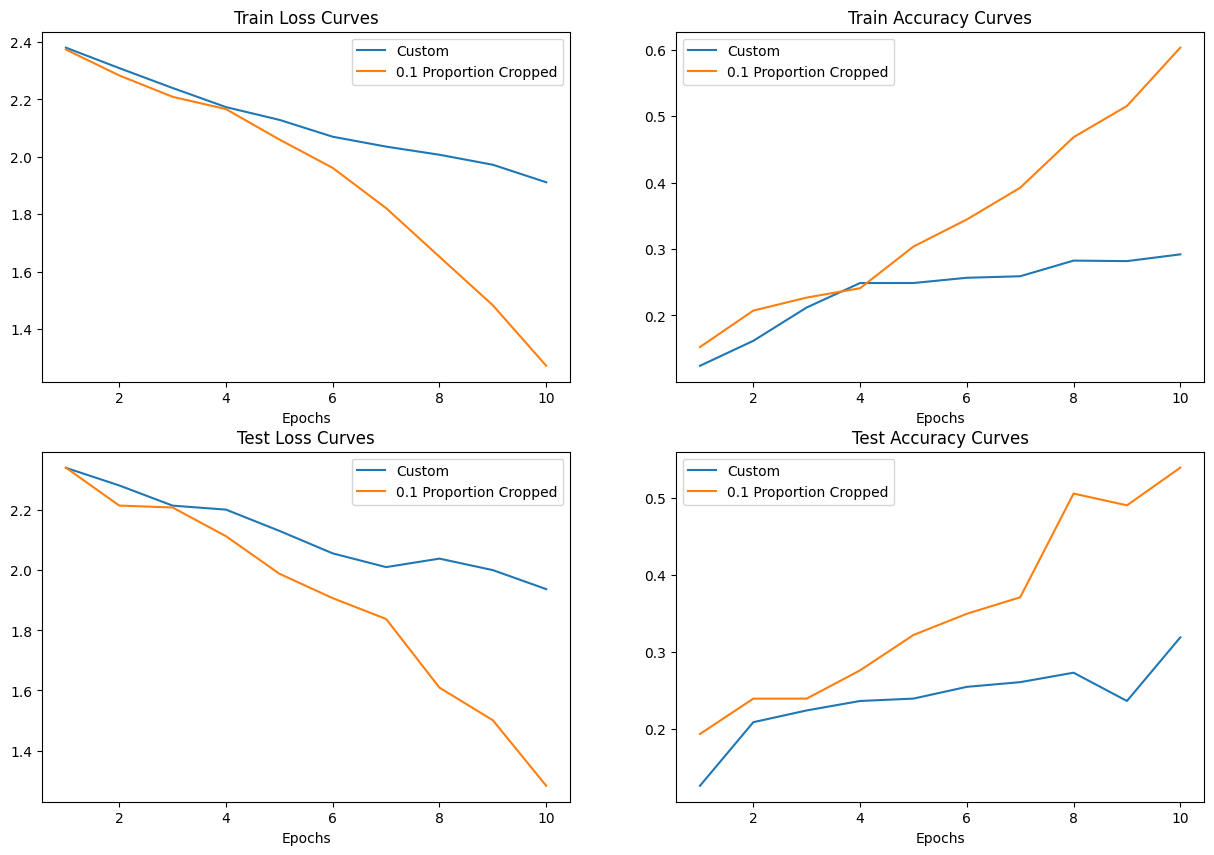

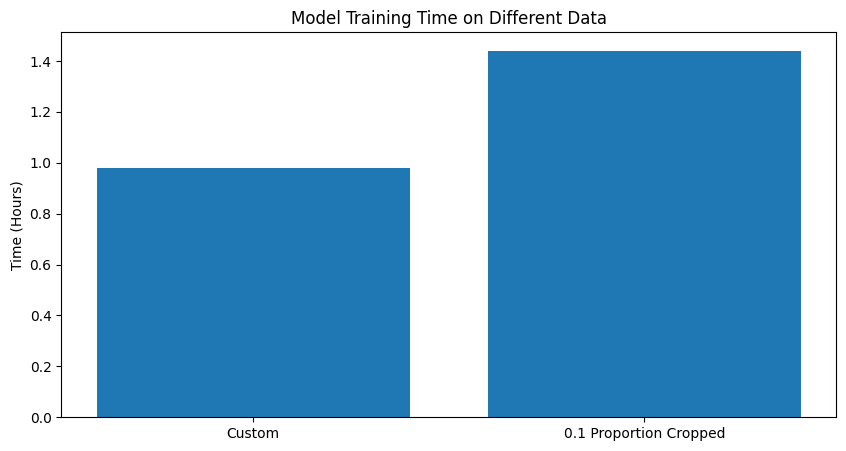

In [ ]:
plt.figure(figsize=(15,10))

for i, label in enumerate(columns):
  plt.subplot(2,2,i+1)

  for j, name in enumerate(graph_dict['Names']):
    plt.plot(range(1, graph_dict['Epochs'][j]+1),
             graph_dict['DataFrames'][j][label].tolist(),
             label = name)

  plt.title(f"{label} Curves")
  plt.xlabel("Epochs")
  plt.legend()

plt.figure(figsize=(10, 5))

for i, time in enumerate(graph_dict['Times']):
  graph_dict['Times'][i] = time / 3600
plt.bar(graph_dict['Names'], graph_dict['Times'])
plt.ylabel("Time (Hours)")
plt.title("Model Training Time on Different Data")
plt.show()